# VGG16 Image Classification
In this example we use a VGG model to perform image classification. 

The VGG model takes 3-channel RGB images of shape Nx3xHxW where H and W are expected to be at least 224. Just like in the SSD example, we can resize images using the `image` actionset. This model also uses mean and standard arrays for normalization. 

Finally, for the output, instead of outputting labels, bounding box coordinates, and probability scores as we would in object detection tasks, the output is a 1000-element array, where each element is a score for each of the 1000 classes that the model was trained on (ImageNet dataset).

We will flatten the outputs so they are easier to deal with.

In [1]:
import swat
from swat import CASTable
from IPython.display import Image

### Connect to CAS

In [2]:
s = swat.CAS("<CAS-HOST>", <CAS-PORT>,"<CAS-USER>")

### Read, check, and describe ONNX file
ONNX model from https://github.com/onnx/models/tree/master/vision/classification/vgg 

In [3]:
# model path
onnxfile = "vgg16-7.onnx"

# read onnx
s.loadactionset('aStore')
with open(onnxfile,'rb') as file:
    blob = file.read()
blob_ = swat.blob(blob)

# check if ONNX model is valid
s.aStore.check(onnx=blob_)

# describe ONNX model
res = s.aStore.describe(onnx=blob_)
print(res)

NOTE: Added action set 'aStore'.
NOTE: It is a valid ONNX model
[AStore.Tab.Description]

 Basic Information
 
               Attribute Value
 0            IR Version     3
 1         Model Version     0
 2                Domain      
 3            Doc String      
 4         Producer Name      
 5      Producer Version      
 6   Operator Set Domain      
 7  Operator Set Version     8

[AStore.Tab.InputValueInfo]

 Input Information
 
    Name    Length ValueType             Shape ElementType
 0  data  602112.0    Tensor  (1, 3, 224, 224)       FLOAT

[AStore.Tab.OutputValueInfo]

 Output Information
 
               Name  Length ValueType      Shape ElementType
 0  vgg0_dense2_fwd  4000.0    Tensor  (1, 1000)       FLOAT

+ Elapsed: 4.37s, user: 0.596s, sys: 1.45s, mem: 1.88mb


From the `Input Information` we can see that the required input shape is (1, 3, 224, 224) so we'll resize images to 224x224

### Load images

In [4]:
s.loadactionset('image')

s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='data',
                  path='/path/to/data',
                  subdirectories=True)
s.image.loadimages(
    path='images',
    caslib='data',
    decode=True,
    addColumns=["CHANNELCOUNT", "CHANNELTYPE", "HEIGHT", "WIDTH"],
    casout=dict(name='imagesOrig',replace=True),
)

NOTE: Added action set 'image'.
NOTE: Cloud Analytic Services added the caslib 'data'.
NOTE: Loaded 10 images from /path/to/data/images into Cloud Analytic Services table imagesOrig.


[OutputCasTables]

                 casLib        Name  Rows  Columns  \
 0  CASUSERHDFS(sasuser)  imagesOrig    10       12   
 
                                             casTable  
 0  CASTable('imagesOrig', caslib='CASUSERHDFS(mac...  

+ Elapsed: 0.472s, user: 0.616s, sys: 0.314s, mem: 345mb

### Resize Images

In [5]:
# no padding or letterbox resizing, just resize to 224x224
encodedImage = True
inputColorOrder = 'RGB'

s.image.processimages(
    table='imagesOrig',
    imagefunctions=[
         dict(functionoptions=dict(functiontype='resize', w=224, h=224))
         ,
         {'options': {'functiontype': 'CONVERT_COLOR', 'type': 'BGR2RGB'}}
       ],
    decode=not encodedImage,
    copyvars=['_height_','_width_'],
    casout=dict(name='imagesResized',replace=True)
)

NOTE: The table IMAGESORIG contains decoded images.
NOTE: 10 of 10 images were processed successfully and saved as encoded images to the Cloud Analytic Services table imagesResized.


[OutputCasTables]

                 casLib           Name  Rows  Columns  \
 0  CASUSERHDFS(sasuser)  imagesResized    10        7   
 
                                             casTable  
 0  CASTable('imagesResized', caslib='CASUSERHDFS(...  

+ Elapsed: 0.0385s, user: 0.0798s, sys: 0.0367s, mem: 173mb

### Load ImageNet 1000 classes
The model was originally trained using the ImageNet dataset which included 1000 classes. We load the classes from a text file "synset.txt" (can be found in the `data` directory)

In [6]:
classfile = "synset.txt"
classes = {}
i = 0
with open(classfile) as f:
    for line in f:
        (key, val) = line.split(" ",1)
        classes[i] = val.strip()
        i += 1

### Save to ASTORE

Set normalization mean and standard arrays
When using a pre-built ONNX, these values are usually provided.


In [7]:
normmean_vals = [0.485, 0.456, 0.406]
normstd_vals = [0.229, 0.224, 0.225]

Flatten inputs

In [8]:
boxldx = [str(i) for i in range(1000)] # score for each of the 1000 classes

Save the ONNX to ASTORE

In [9]:
s.aStore.saveas(
           table="imagesResized",
           rstore=dict(name="vggStore", replace=True),
           onnx=blob_,
           inputs=[dict(vars=["_image_"],shape=[1,3,224,224],varbinaryType="UINT8", 
                        inputShapeOrder='NHWC', inputColorOrder='BGR',
                        modelShapeOrder='NCHW', modelColorOrder='RGB',
                        preprocess='NORMALIZE', normFactor=255,
                        normmean=normmean_vals,
                        normstd=normstd_vals)],
            outputs=[dict(name="output", shape=[1,1000], labels=boxldx, labeldim=[1], postprocess='SOFTMAX')],
           )

NOTE: 553699715 bytes were written to the table "vggStore" in the caslib "CASUSERHDFS(sasuser)".


+ Elapsed: 10.7s, user: 8.99s, sys: 7.94s, mem: 1.59e+03mb

### Describe newly generated ASTORE

In [10]:
s.aStore.describe(rstore="vggStore")

[Key]

 Store Key
 
                                         Key
 0  6B7EAF0AF69DEEA0C85EB8D5ECF8CA8327529257

[Description]

 Basic Information
 
          Attribute               Value
 0  Analytic Engine                onnx
 1     Time Created  23Nov2021:19:18:53

[InputVariables]

 Input Variables
 
       Name   Length Role Type    RawType FormatName
 0  _image_  39221.0   Id       Character           

[OutputVariables]

 Output Variables
 
             Name  Length Type                  Label
 0      P_output0     8.0  Num    Predicted: output=0
 1      P_output1     8.0  Num    Predicted: output=1
 2      P_output2     8.0  Num    Predicted: output=2
 3      P_output3     8.0  Num    Predicted: output=3
 4      P_output4     8.0  Num    Predicted: output=4
 ..           ...     ...  ...                    ...
 995  P_output995     8.0  Num  Predicted: output=995
 996  P_output996     8.0  Num  Predicted: output=996
 997  P_output997     8.0  Num  Predicted: output=997
 998  P_output998     8.0  Num  Predicted: output=998
 999  P_output999     8.0  Num  Predicted: output=999
 
 [1000 rows x 4 columns]

+ Elapsed: 3.65s, user: 5.81s, sys: 0.671s, mem: 550mb

We can see from the output table above that there are 1000 `P_output{}` columns, 1 column for the predicted probability of each class.

### Score image data with ASTORE

In [11]:
s.aStore.score(rstore="vggStore", 
               table="imagesResized", 
               out=dict(name="out", replace=True),
               copyvars=("_path_")
              )

[OutputCasTables]

                 casLib Name  Rows  Columns  \
 0  CASUSERHDFS(sasuser)  out    10     1001   
 
                                         casTable  
 0  CASTable('out', caslib='CASUSERHDFS(sasuser)')  

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.473238  0.089228
 1  Creating the State  4.647205  0.876220
 2             Scoring  0.182983  0.034501
 3               Total  5.303699  1.000000

+ Elapsed: 5.43s, user: 19.5s, sys: 2.79s, mem: 664mb

Specifying the variable “_path_” in the copyvars makes it easier to keep track of which scores correspond to which images. The following table shows an example of what the output looks like. 

In [12]:
cas_results = s.CASTable("out")
cas_results.head()

Selected Rows from Table OUT

      P_output0     P_output1     P_output2     P_output3     P_output4  \
0  5.556921e-07  1.437692e-07  9.500785e-08  3.862417e-08  8.886101e-07   
1  6.424655e-06  3.798775e-07  1.102523e-05  5.905290e-05  1.056478e-04   
2  1.403092e-06  3.720949e-06  1.055056e-05  1.894453e-05  2.466823e-05   
3  1.956023e-05  1.173395e-05  6.763024e-05  1.383957e-04  1.276258e-04   
4  1.548991e-06  9.443657e-07  5.517280e-05  2.688887e-05  3.759456e-05   

      P_output5     P_output6  P_output7  P_output8     P_output9  ...  \
0  5.505138e-07  3.898815e-07   0.000015   0.000002  2.121748e-07  ...   
1  2.406840e-05  2.123534e-04   0.000638   0.000038  1.972145e-06  ...   
2  1.317809e-05  4.758083e-06   0.000002   0.000002  5.155478e-07  ...   
3  1.191072e-04  5.141500e-05   0.000205   0.000406  2.852110e-05  ...   
4  1.165263e-05  1.781924e-05   0.000026   0.000079  4.352216e-05  ...   

    P_output991   P_output992   P_output993   P_output994   P_output995  \
0  1.070685e-07  1.444886e-08  9.946037e-08  5.297076e-08  5.886420e-08   
1  9.751583e-08  3.706191e-08  3.429969e-07  2.377661e-08  3.479564e-07   
2  8.095262e-07  8.046799e-07  8.469519e-07  3.298420e-06  1.530229e-06   
3  1.722776e-05  2.538630e-05  3.927593e-06  1.588027e-06  6.142308e-06   
4  8.383523e-07  6.261212e-07  4.823835e-07  6.960358e-07  5.246879e-06   

   P_output996   P_output997   P_output998  P_output999  \
0     0.000001  1.156396e-08  4.311255e-07     0.000061   
1     0.000017  2.885142e-07  8.120585e-07     0.000008   
2     0.000017  1.192237e-05  4.152527e-05     0.000013   
3     0.000062  2.708991e-06  4.137054e-05     0.006323   
4     0.000005  2.148735e-06  1.316911e-05     0.000463   

                                     _path_  
0   /path/to/data/images/image7.jpg          
1  /path/to/data/images/image10.jpg          
2   /path/to/data/images/image0.jpg          
3  /path/to/data/images/image16.jpg          
4  /path/to/data/images/image19.jpg          

[5 rows x 1001 columns]

### Post-process results 
Convert results to dictionary for Python post-processing

In [13]:
sas_results = cas_results.to_dict()

As mentioned previously, each output corresponds to a specific class. We can import these classes into a dictionary and then use that to convert these class indices to text. Since “SOFTMAX” was specified in postprocessing, the classifications are more greatly differentiated, making it easier to extract the higher scored classes. 

An example of further post-processing would be to extract the top classifications for each image scored.

In [14]:
# get indices and scores for any class that has a predicted probability over the specified threshold
def get_best_classes(sas_results,imgnum,classlist,threshold=.2):
    pred_classes = []
    for i in range(1000):
        if sas_results['P_output{}'.format(i)][imgnum] > .2:
            cls_name = get_class(i,classlist)
            pred_classes.append((cls_name,sas_results['P_output{}'.format(i)][imgnum]))
    return pred_classes

In [15]:
# get the class name from the predicted index
def get_class(index, classlist):
    return classlist[index]

In [16]:
# print data in a nicely formatted table
def print_table(header):
    data = [header]
    data.extend(pred_classes)
    dash = '-' * 40
    for i in range(len(data)):
        if i == 0:
            print(dash)
            print('{:<20s}{:>4s}'.format(data[i][0],data[i][1]))
            print(dash)
        else:
            print('{:<20s}{:>4f}'.format(data[i][0].split(",")[0],data[i][1]))

In [17]:
# plot image with it's predicted class and probability score
def print_predictions(sas_results,best_classes,root_dir,imgnum,classlist):
    img_name = sas_results['_path_'][imgnum].split(r"/")[-1]
    impath = "{0}\{1}".format(root_dir,img_name)
    pil_img = Image(filename=impath)
    display(pil_img)
    
    header = ("PREDICTED CLASS","SCORE")
    print_table(header)

### Print images and their predicted classes and scores

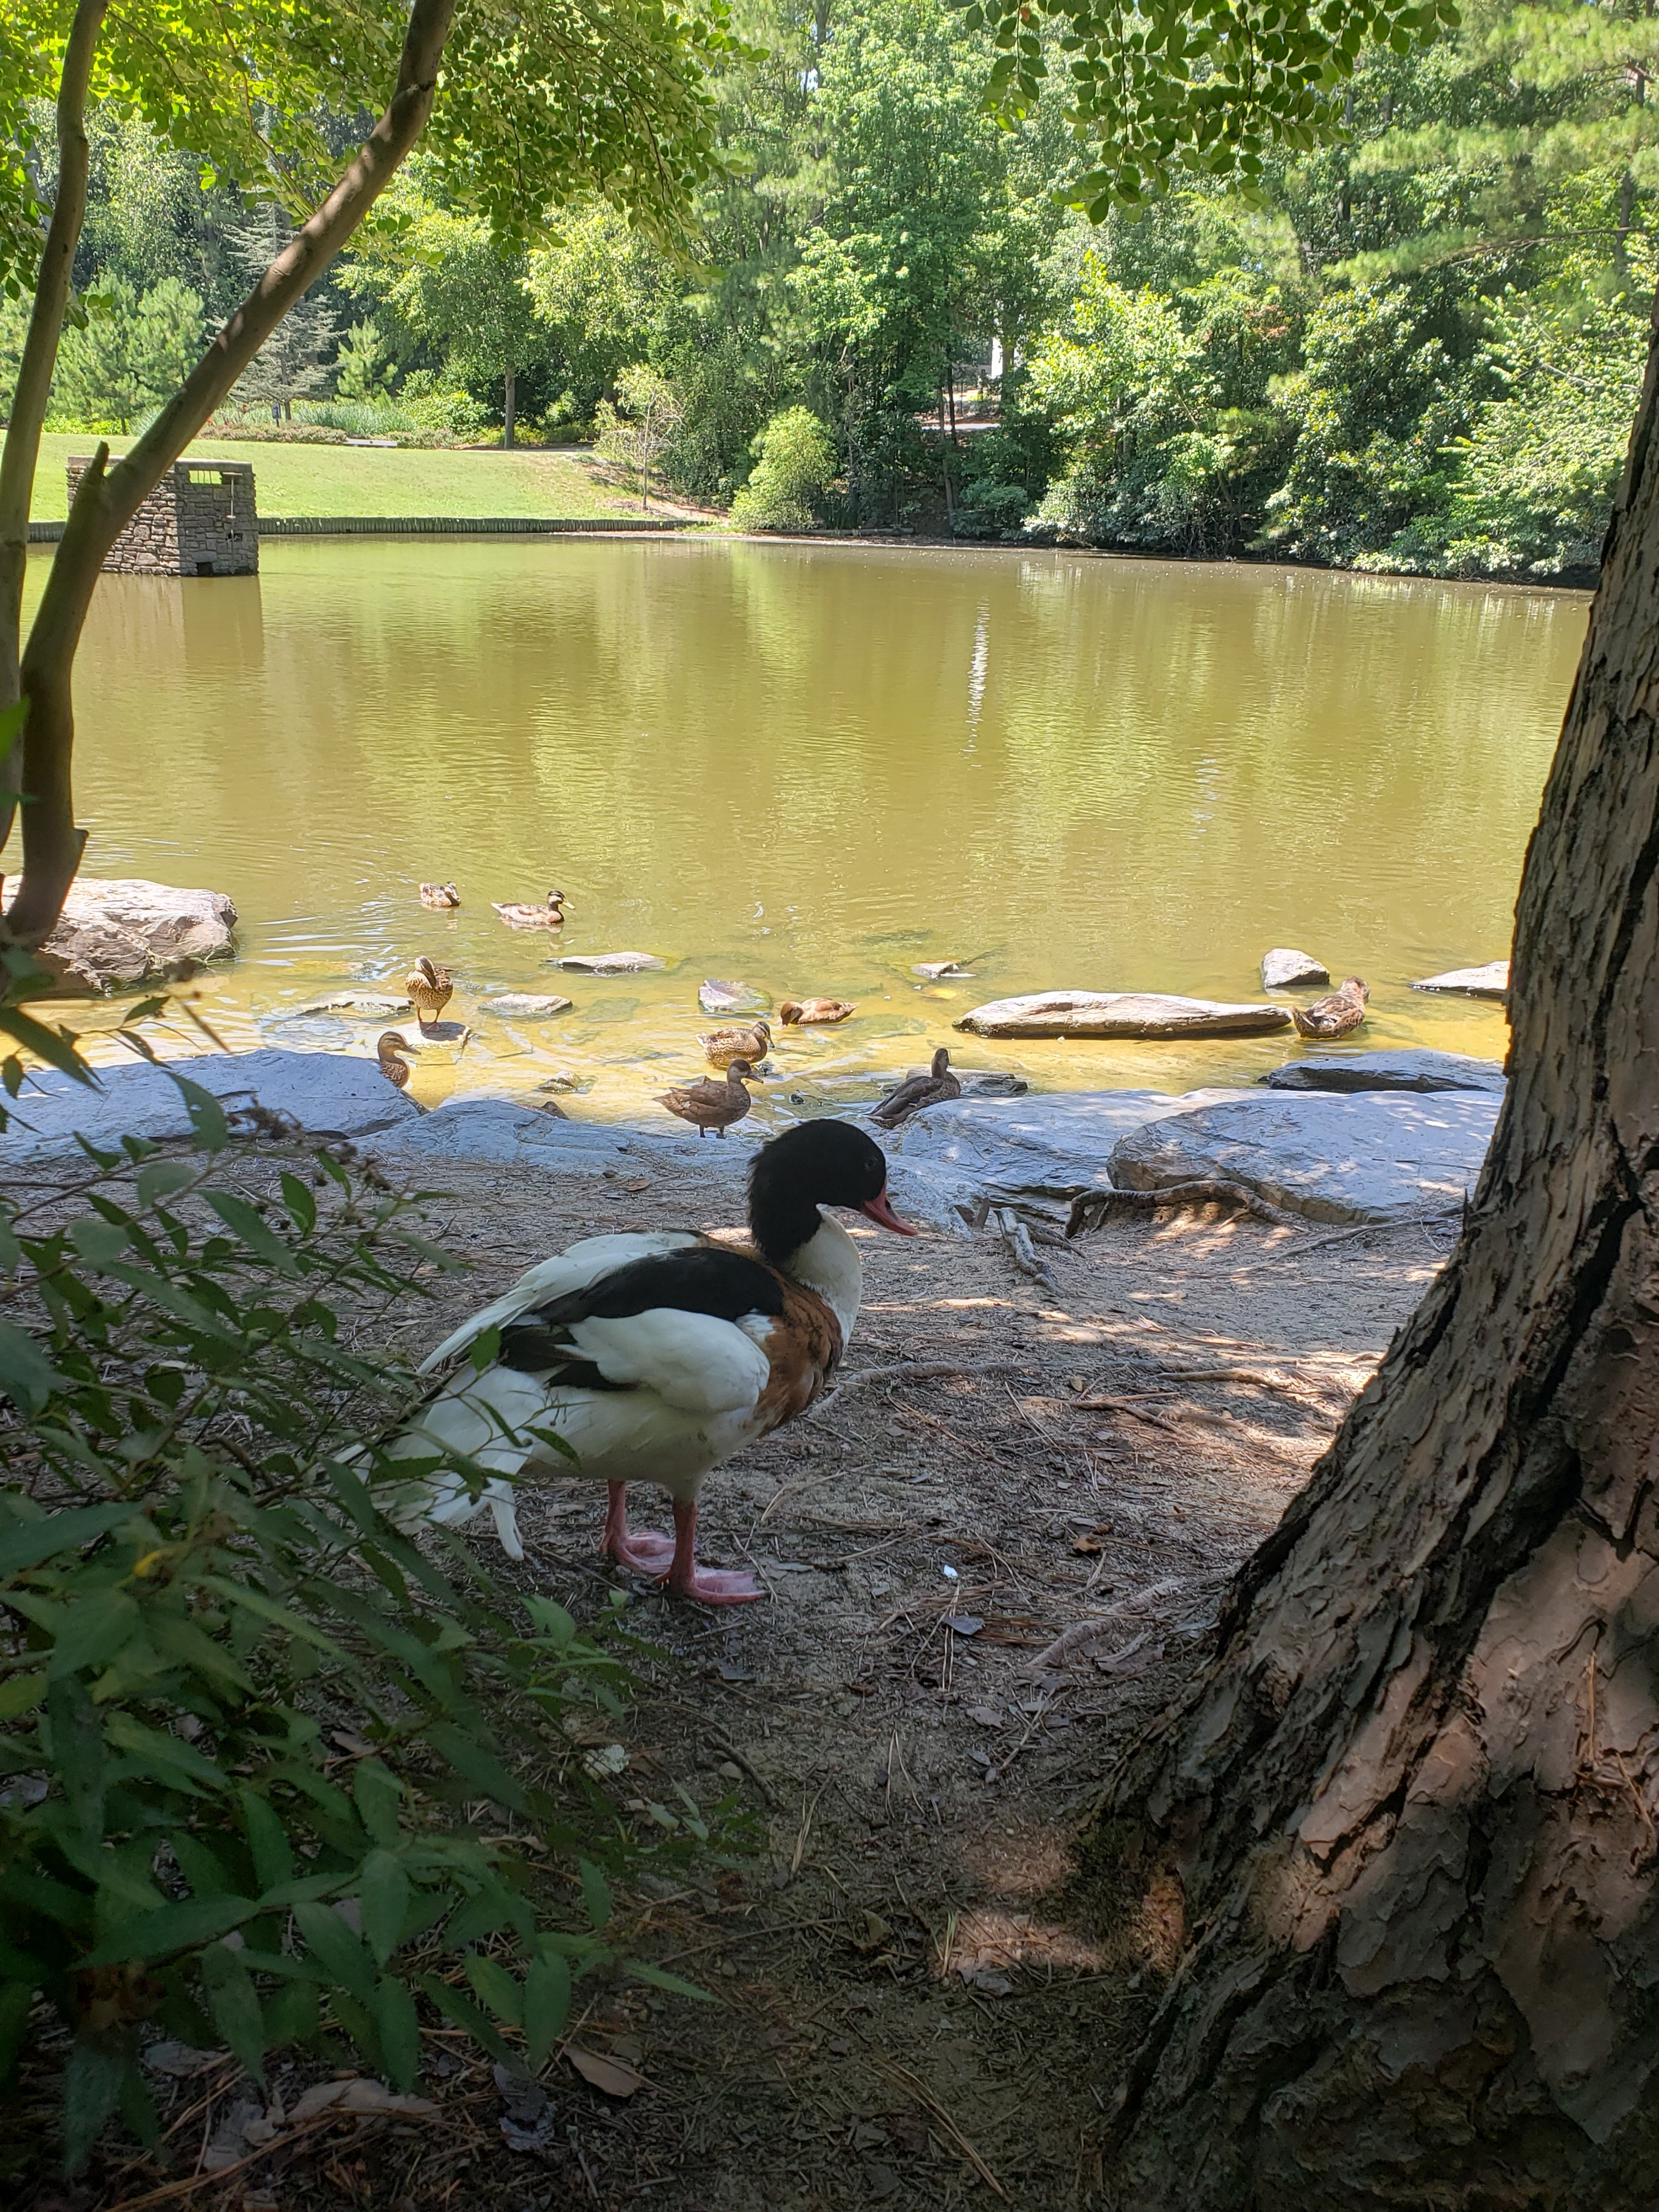

----------------------------------------
PREDICTED CLASS     SCORE
----------------------------------------
lakeside            0.786475


In [18]:
imgroot = "/path/to/data/images"
for imgnum in range(len(sas_results["_path_"])):
    pred_classes = get_best_classes(sas_results,imgnum,classes)
    print_predictions(sas_results,pred_classes,imgroot,imgnum,classes)

If you specify the option INTOFORMATTEDLEN in the SAVEAS statement of proc ASTORE, an _INTO_ column will be added to the output table and populated with the class with the highest score.